# Implementación de Gradiente Descendente en Julia-0.4.5

Hace unas semanas atrás me tocó ser parte de la organización de una reunión del grupo de Data Scientists de Chile, que tiene su origen en LinkedIn. Dentro de las conversaciones salió como tópico la potencialidad del lenguaje **Julia**, que puede ser una interesante alternativa para implementar algoritmos de Machine Learning.

**Julia** es el jugador más nuevo dentro de los lenguajes utilizados para Machine Learning. Su primera aparición data del año 2012, a consecuencia de un anhelado desafío por parte de sus desarrolladores: Jeff Bezanson, Stefan Karpinski, Viral Shah, y Alan Edelman, para crear un lenguaje de alto nivel que fuese tan sencillo de usar como Python, tan poderoso como Matlab y tan rápido como C. El resultado final es Julia.

Para probar estas aseveraciones, me puse como desafío implementar el algoritmo quizá más sencillo e introductorio de los cursos de Machine Learning: el Gradiente Descendente aplicado sobre regresiuón lineal.

Para ello generé un modelo lineal en Excel, al cual le introduje desviaciones aleatorias para así tener una nube de puntos con la cual probar el algoritmo.

A continuación se presenta la secuencia de comandos usados para la implementación del algoritmo, considerando una etapa previa de inspección de los datos. Para examinar gráficamente la nube, utilicé el paquete **Gadfly**, que es uno de los recomendados para graficar por los usuarios de **Julia**.

## Inspección inicial

In [405]:
# Carga de librerías
using Gadfly;
using DataFrames;

In [449]:
# Lectura de set demo (2 variables (x1 e Y), 50 datos en total)
df = readtable("data_regresion_lineal.txt", header=true);

In [463]:
# Estadísticas básicas del set de datos
describe(df)

x1
Min      0.7
1st Qu.  13.275
Median   25.4
Mean     25.511999999999997
3rd Qu.  37.699999999999996
Max      50.1
NAs      0
NA%      0.0%

y
Min      71.4
1st Qu.  447.45
Median   784.25
Mean     751.8560000000001
3rd Qu.  1048.4
Max      1420.8
NAs      0
NA%      0.0%



In [451]:
# Una muestra de los primeros 10 registros
df[1:10,:]

,x1,y
1,0.7,330.8
2,2.1,246.3
3,3.0,356.5
4,4.0,353.7
5,5.1,71.4
6,6.1,446.7
7,6.9,449.7
8,7.9,466.5
9,9.0,341.1
10,10.0,230.0


In [459]:
# Tamaño del set de datos
@printf("filas: %d, columnas: %d\n",size(df,1),size(df,2))

filas: 50, columnas: 2


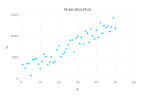

In [462]:
# Examen gráfico de datos
plot(x=df[:x1],y=df[:y],Geom.point, Guide.title("Nube de puntos"))

## Implementación de las funciones de costo $J(\Theta)$ y gradiente $\nabla J(\Theta)$ para el algoritmo

Para la construcción de las funciones, se usaron las versiones vectorizadas y matriciales de costo y gradiente:

In [409]:
# Función de costo
function J(Theta,X,Y)
    m = length(Y);
    (X*Theta-Y)'*(X*Theta-Y)/m;
end

J (generic function with 1 method)

In [410]:
# Función Nabla de J
function nabla(Theta,X,Y)
    ((X'*X)*Theta - X'*Y);
end

nabla (generic function with 1 method)

In [464]:
# Gradiente
function gradiente(X,Y,Theta,alpha,epsilon)
    m = length(Y);
    Jhist = [];
    n = 1
    while alpha*norm(nabla(Theta,X,Y)) > epsilon
        temp = Theta - alpha * nabla(Theta,X,Y)/m;
        Theta = temp;
        push!(Jhist,J(Theta,X,Y)[1]) # El subíndice 1 es porque J es matriz de 1x1
        n += 1;
    end
    return (Jhist,Theta,n)
end

gradiente (generic function with 1 method)

## Inicialización de variables e iteración para $\alpha = 0.001$ y $\epsilon > 0.001$

In [465]:
# Inicialización
X = [ones(50) df[:x1]];
Y = df[:y];

In [466]:
# Iteraciones para a = 0.001 y epsilon = 0.001
@time (Jhist,Theta,n) = gradiente(X,Y,[0,0],0.001,0.001);

  0.901631 seconds (3.88 M allocations: 266.547 MB, 6.98% gc time)


In [467]:
#Número de iteraciones
n

31788

In [468]:
# Parámetro Theta
Theta

2-element DataArrays.DataArray{Float64,1}:
 186.246 
  22.1696

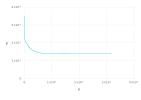

In [469]:
# Curva de costo
plot(x=1:length(Jhist),y=Jhist,Geom.line)

## Recta ajustada y solución algebraica por Mínimos Cuadrado Ordinarios

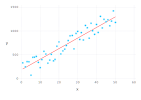

In [433]:
# Recta ajustada
plot(layer(x=df[:x1],y=df[:y],Geom.point),layer(x=df[:x1],
y=Theta[1]+Theta[2]*df[:x1],Geom.line,Theme(default_color=color("red"))))

In [434]:
# Resultado exacto: Mínimos Cuadrados Ordinarios
Beta = pinv(X'*X)*(X'*Y)

2-element DataArrays.DataArray{Float64,1}:
 186.328 
  22.1671

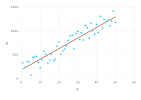

In [435]:
# Recta ajustada con Beta superpuesta
plot(layer(x=df[:x1],y=df[:y],Geom.point),layer(x=df[:x1],
y=Theta[1]+Theta[2]*df[:x1],Geom.line,Theme(default_color=color("red"))),
layer(x=df[:x1],y=Beta[1]+Beta[2]*df[:x1],Geom.line,Theme(default_color=color("green"))))

In [441]:
# Error general
norm(Beta-Theta)^(0.5)

0.28696690961730725

Se puede observar que el resultado obtenido es lo esperable por el algoritmo. Después de 31.788 iteraciones en 0.9 segundos, se obtuvieron los valores de $\theta_0$ y $\theta_1$, con una muy pequeña diferencia respecto del valor obtenido por la solución algebraica de Mínimos Cuadrados Ordinarios.

En términos de la usabilidad, es muy cómodo poder utilizar las fórmulas vectorizadas y es agradable la velocidad de ejecución. Para una prueba más definitiva, probaré el algoritmo con un set de datos más grande y con más variables, y también haré un paralelo con Octave para probar velocidad.

Pero más allá de la mera eficacia computacional, me agradó mucho como lenguaje, y creo que de comprobarse las aseveraciones de sus creadores, fácilmente podría transformarse en mi herramienta predilecta para análisis de datos y Machine Learning.

<h6 style="text-align: right">Rodrigo Abt B., Ing. Civil Industrial U. de Chile<br>Consultor y Data Scientist</h6>